# Dataset과 Dataloader
- 데이터 샘플을 처리하는 코드는 지저분할 수 있다.
- 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습코드로부터 분리하는 것이 이상적이다.
- `torch.utils.data.Dataloader` 와 `torch.utils.data.Dataset`의 두 가지 데이터 기본 요소를 제공하여,
미리준비해둔 데이터셋(FashionMNIST 등) 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다.
- `Dataset` : 샘플과 정답을 저장
- `Dataloader` : `Dataset` 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감싼다.



## 데이터셋 불러오기
- `Torchvision`에서 Fashion-MNIST 데이터셋을 불러와보자.
- 흑백의 28x28 이미지와 10개의 분류(class)중 하나인 정답으로 이루어져있다.
```
{
    root : 학습/테스트 데이터가 저장되는 경로이다.
    train : 학습용 혹은 테스트용 데이터셋 여부를 지정한다.
    download=True 는 root에 데이터가 없는 경우 인터넷으로 다운로드한다.
    transform과 target_transform : 특징과 정답 변형을 지정한다.
}
```

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform= ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download= True,
    transform= ToTensor()
)

## 데이터 순회 및 시각화
- 데이터셋에 리스트처럼 직접 접근할 수 있다.
- `training_data[index]`나 `plt`를 사용하여 학습 데이터 일부를 시각화해보자.

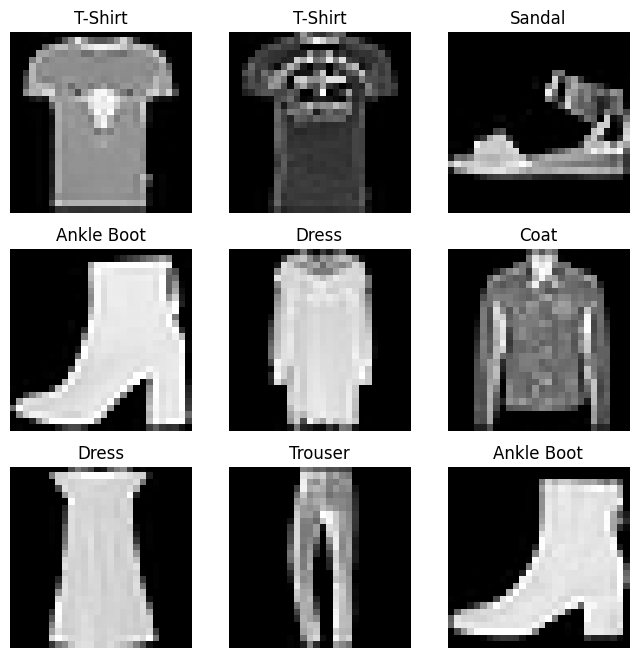

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize = (8,8))
rows, cols = (3,3)

for i in range(1, rows*cols + 1):
    sample_idx = torch.randint(len(training_data), size = (1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
    
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기
- 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다.
- `__init__` , `__len__` , `__getitem__`
- 아래 구현을 살펴보면 FashionMNIST 이미지들은 `img_dir` 디렉터리에 저장되고, 정답은 `annotations_file` CSV파일에 저장됨
- label.csv 예시   
    ```
    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ...
    ank999.jpg, 9
    ```

In [13]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        transform = None,
        target_transform = None
    ):
        """ __init__은 Dataset 객체가 생성될 때 한번만 생성된다.
        이미지와 주석파일(annotatios.file)이 포함된 디렉터리와 두가지 변형(transform)을 초기화한다.

        Args:
            annotations_file (_type_): _description_
            img_dir (_type_): _description_
            transform (_type_, optional): _description_. Defaults to None.
            target_transform (_type_, optional): _description_. Defaults to None.
        """
        self.img_labels = pd.read_csv(annotations_file, names = ['file_name','label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(
        self
    ):
        """ 데이터셋 샘플 개수를 반환한다.

        Returns:
            _type_: _description_
        """
        return len(self.img_labels)
    
    def __getitem__(
        self,
        idx
    ):
        """ 주어진 인덱스 `idx`에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.
        인덱스를 기반으로 디스크에서 이미지의 위치를 식별, `read_image`를 사용하여 이미지를 텐서로 변환하며
        `self.img_labels`의 csv데이터로 정답을 가져오고 transform 함수를 호출하고 텐서 이미지와 라벨을 dict()로 바꾼다.

        Args:
            idx (_type_): _description_

        Returns:
            _type_: _description_
        """
        img_path = os.path.join(
            self.img_dir, self.img_labels.iloc[idx,0]
        )
        image = read_image(img_path)
        label = self.img_labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## DataLoader 로 학습용 데이터 준비하기
- `Dataset`은 데이터셋의 특징을 가져오고, 하나의 샘플에 정답을 지정하는 일을 한 번에 한다.
- 모델 학습 시, 일반적으로 샘플들을 `mini batch`로 전달하고 매 epochs마다 데이터를 다시 섞어서 과적합 방지하고, python의 `multiprocessing` 을 사용하여 데이터 검색속도를 높인다.
- `Dataloader` 는 간단한 API로, 이 과정을 추상화한 순회 가능한 객체(iter)이다.

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    training_data,
    batch_size=64,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=64,
    shuffle=True
)

## DataLoader로 순회하기
- `DataLoader`에 데이터셋을 불러온 뒤에, 필요에 따라 데이터셋을 순회할 수 있다.
- 아래 코드 각 순회는 `train_features`와 `train_labels`의 묶음 (batch)를 반환한다.
- shuffle은 모든 배치를 순회한 뒤 데이터를 섞는다.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


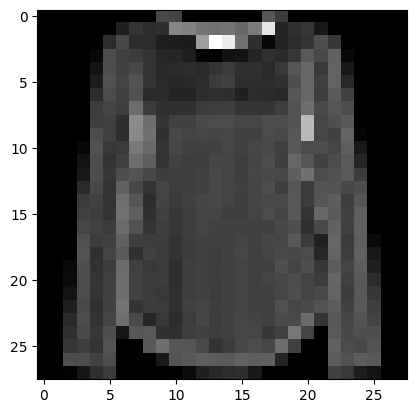

label : 6


In [17]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = "gray")
plt.show()
print(f"label : {label}")

## Ref
[Dataloader API](https://pytorch.org/docs/stable/data.html)